## **Project: Bank Customer Churn**

In [1]:
import pandas as pd

### **Import the Data**

In [2]:
## Read the dataset
customer = pd.read_csv('./Bank+Customer+Churn/Bank_Churn.csv')

In [3]:
customer.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [40]:
data = customer.drop(['CustomerId','Surname','Exited'], axis=1)

In [41]:
data.shape

(10000, 10)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


### **Data Cleansing and Prep: Convert all categorical features to numeric**

In [43]:
geo_num = pd.get_dummies(data.Geography,dtype='int')

In [44]:
import numpy as np
gender_num = pd.DataFrame(np.where(data.Gender == 'Male',1,0),columns=['Gender'])

In [45]:
data = pd.concat(
    [data.drop('Gender',axis=1),
     geo_num,gender_num],axis=1).drop('Geography',axis=1)

In [46]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Gender
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.501400,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.500023,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,1.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,1.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [51]:
data['ProductsPerYear'] = np.where(
    data['Tenure']==0,
    data['NumOfProducts'],
    data['NumOfProducts']/data['Tenure']
)

### **Cluster/ Segment the Customers**

In [56]:
## Standardize the data
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
data_std = pd.DataFrame(std.fit_transform(data), columns=data.columns)

In [64]:
## Fot K-Means Clustering models with 2-15 clusters
## Create an inertia and silhouette score plot

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_values = []
silhouette_values = []

for k in range(2,16):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit_transform(data_std)
    inertia_values.append(km.inertia_)
    silhouette_values.append(
        silhouette_score(data_std,km.labels_,metric='euclidean',random_state=42)
    )


In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

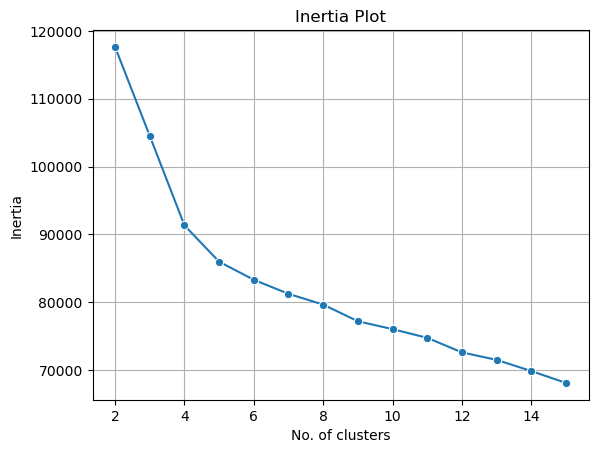

In [75]:
## Inertia Plot
sns.lineplot(
    # data=inertia_values,
    x=range(2,16),
    y=inertia_values,
    marker='o',
    linestyle='-',
)
plt.xlabel('No. of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.title('Inertia Plot')
plt.show();

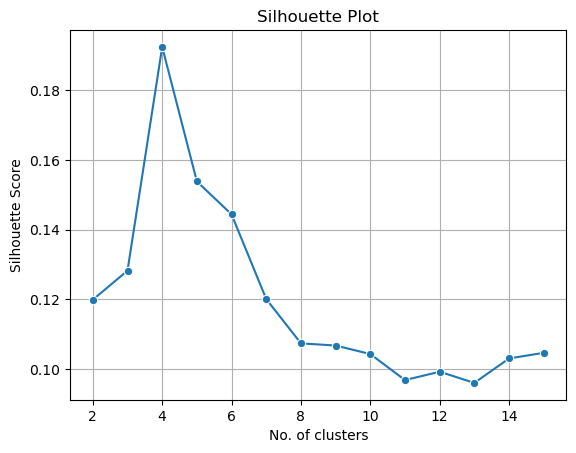

In [77]:
## Silhouette Plot
sns.lineplot(
    x=range(2,16),
    y=silhouette_values,
    marker='o',
    linestyle='-',
)
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.title('Silhouette Plot')
plt.show();

In [81]:
## From the inertia and silhouette plots using k=4 for fitting
km4 = KMeans(n_clusters=4,n_init='auto',random_state=42)
km4.fit_transform(data_std);

In [83]:
cluster_df = pd.DataFrame(km4.labels_,columns=['clusters'])

In [88]:
## Check the number of customers in each cluster
pd.concat([data,cluster_df],axis=1)['clusters'].value_counts()

clusters
3    4637
2    2336
1    2329
0     698
Name: count, dtype: int64

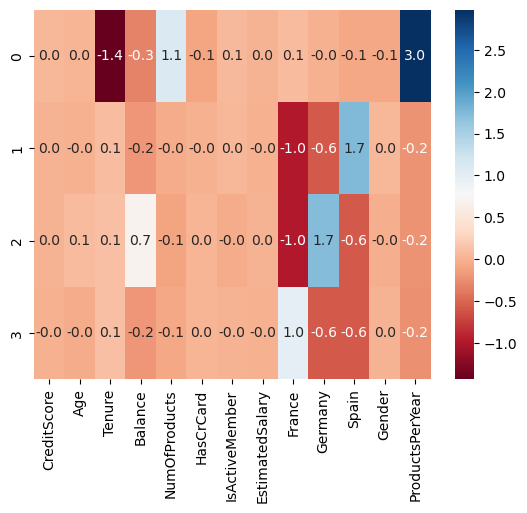

In [89]:
## Create a heatmap with the cluster centers
sns.heatmap(
    data = pd.DataFrame(km4.cluster_centers_,columns=data_std.columns),
    annot=True,
    fmt='0.1f',
    cmap='RdBu'
);

## Interpretation:
- Cluster 1: Customers purchasing more products in short time
- Cluster 2: Spanish customers
- Cluster 3: German customers
- Cluster 4: French customers

### **Cluster the Customers (Round 2)**

In [90]:
## Exclude the country fields
data_std_2 = data_std.drop(['France','Spain','Germany'],axis=1)

In [91]:
data_std_2

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,ProductsPerYear
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,-1.095988,-0.016781
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,-1.095988,0.967674
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,-1.095988,-0.262894
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,-1.095988,2.936584
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,-1.095988,-0.016781
...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,0.007457,-0.004426,-1.225848,0.807737,0.646092,-1.030670,-0.066419,0.912419,-0.213672
9996,-1.391939,-0.373958,1.724464,-0.306379,-0.911583,0.646092,0.970243,0.027988,0.912419,-0.804344
9997,0.604988,-0.278604,0.687130,-1.225848,-0.911583,-1.547768,0.970243,-1.008643,-1.095988,-0.719963
9998,1.256835,0.293517,-0.695982,-0.022608,0.807737,0.646092,-1.030670,-0.125231,0.912419,0.311371


In [92]:
## Fot K-Means Clustering models with 2-15 clusters
## Create an inertia and silhouette score plot

inertia_values = []
silhouette_values = []

for k in range(2,16):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit_transform(data_std_2)
    inertia_values.append(km.inertia_)
    silhouette_values.append(
        silhouette_score(data_std_2,km.labels_,metric='euclidean',random_state=42)
    )


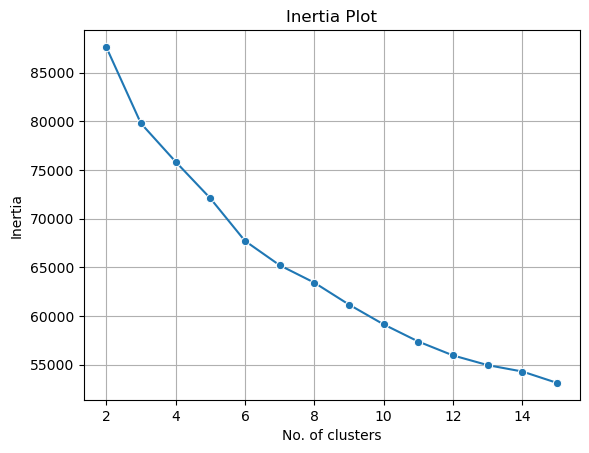

In [93]:
## Inertia Plot
sns.lineplot(
    x=range(2,16),
    y=inertia_values,
    marker='o',
    linestyle='-',
)
plt.xlabel('No. of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.title('Inertia Plot')
plt.show();

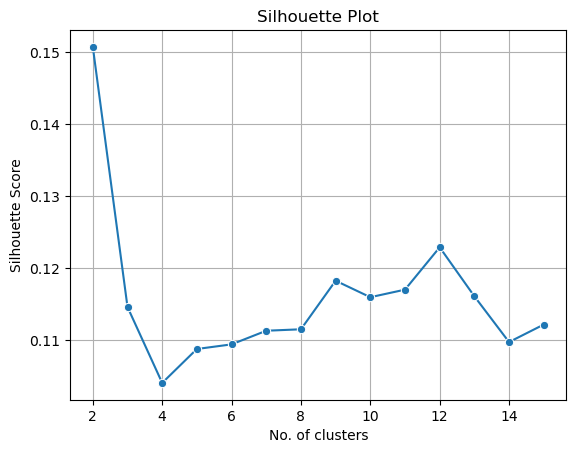

In [94]:
## Silhouette Plot
sns.lineplot(
    x=range(2,16),
    y=silhouette_values,
    marker='o',
    linestyle='-',
)
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.title('Silhouette Plot')
plt.show();

In [97]:
## From the inertia and silhouette plots using k=5 for fitting
km5 = KMeans(n_clusters=5,n_init='auto',random_state=42)
km5.fit_transform(data_std_2);

In [98]:
cluster_df = pd.DataFrame(km5.labels_,columns=['clusters'])

In [99]:
## Check the number of customers in each cluster
pd.concat([data,cluster_df],axis=1)['clusters'].value_counts()

clusters
1    2983
3    2921
2    2225
4    1157
0     714
Name: count, dtype: int64

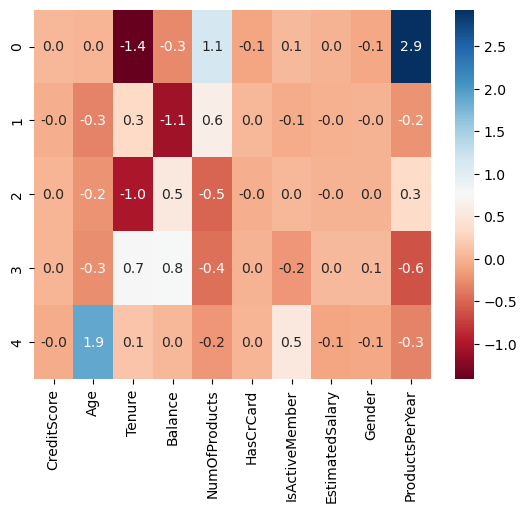

In [101]:
## Create a heatmap with the cluster centers
sns.heatmap(
    data = pd.DataFrame(km5.cluster_centers_,columns=data_std_2.columns),
    annot=True,
    fmt='0.1f',
    cmap='RdBu'
);

## Interpretation:
-  Cluster 1: Customers purchasing more products in short time
-  Cluster 2: Customers with low account balance
-  Cluster 3: Customers whose tenures are less
-  Cluster 4: Customers purchasing less products
-  Cluster 5: Senior customers

### **Explore the clusters and make recommendations**

In [104]:
## Create a new dataframe combining the origonal df with the clusters
customers_df = pd.concat([customer,pd.Series(km5.labels_,name='clusters')],axis=1)

In [114]:
mapper = {
    0:'Customers purchasing more products in short time',
    1:'Customers with low account balance',
    2:'New Customers',
    3:'Customers purchasing less products',
    4:'Senior customers'
    
}

customers_df['cluster_name'] = cluster_df['clusters'].map(mapper)

In [117]:
customers_df = customers_df.drop(['clusters'],axis=1)

In [118]:
customers_df.groupby('cluster_name')['Exited'].mean().sort_values(ascending=False)

cluster_name
Senior customers                                    0.394987
Customers purchasing more products in short time    0.221289
New Customers                                       0.209888
Customers purchasing less products                  0.204382
Customers with low account balance                  0.120013
Name: Exited, dtype: float64

In [123]:
pd.DataFrame(customers_df.groupby(['cluster_name','Geography'])['Geography'].count())

Geography
cluster_name                                     Geography           
Customers purchasing less products               France          1222
                                                 Germany         1097
                                                 Spain            602
Customers purchasing more products in short time France           370
                                                 Germany          185
                                                 Spain            159
Customers with low account balance               France          1886
                                                 Germany          150
                                                 Spain            947
New Customers                                    France           985
                                                 Germany          756
                                                 Spain            484
Senior customers                                 France           551
                                                 Germany          321
                                                 Spain            285